<a href="https://colab.research.google.com/github/Rogerio-mack/Research-Literature-Review-APIs/blob/main/search_scopus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Literature review from [Scopus](https://www.scopus.com/search/form.uri?display=basic#basic)

**`keyword`** = 'supply chain resilience'

In [ ]:
#@markdown Setups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [ ]:
#@markdown **DO NOT RUN THIS HERE**. 
#@markdown *You should run this from your locally in your computer using authorized scopus VPN*
#@markdown *in other to create a file to be loaded here.*

# -*- coding: utf-8 -*-
"""
Created on Sat Feb 19 13:33:39 2022

@author: User
"""
import numpy as np
import pandas as pd
import requests  # Import the requests library
import json
import pprint # nicely json print
import time

# https://dev.elsevier.com/sc_api_spec.html documentation 
# https://dev.elsevier.com/search.html#/Scopus_Search iterative api
# file:///C:/Users/User/Documents/Mack2022/DX%20Analytics/Basic-APIs.pdf nice documentation

apikey = 'apiKey=YOUR-API-KEY'

keyword = 'all(supply chain resilience)'
max_search = 5000 # total search
limit = 100 # each search, max is 100 from api documentation!
print_json = False

apiquery = '&query=' + keyword

apiscopus = 'https://api.elsevier.com/content/search/scopus?' 
apifields = '&field=dc:identifier,dc:title,citedby-count,prism:coverDate,dc:creator,author,dc:description'
# apifields = '&field=dc:identifier,dc:title,dc:description,citedby-count'
apicount = '&count='
apistart = '&start='

url = apiscopus + apikey + apiquery + apifields + apicount + str(1) + apistart + str(0)
res = requests.get(url, headers={'Accept':'application/json'}) 

if res.status_code ==200:
    payload = res.json()
    total = int(payload['search-results']['opensearch:totalResults'])
    if (total > 0):
      print(f"Total of keyword search results: {total}")
      max = min(max_search,total)
      print()
    else:
      print(f"No results for  keyword search: {keyword}")
      print()
      max = 0 # scape loop for search results
else:
    print(f"Request returned {res.status_code} : '{res.reason}'") 
    max = 0 # scape loop for search results

all_items = []

for offset in range(0, max, limit):
    
  url = apiscopus + apikey + apiquery + apifields + apicount + str(limit) + apistart + str(offset)  
  res = requests.get(url)  # Make a GET request to the URL
 
  print('running...' , offset)    
  print(url)  

  payload = res.json()  # Parse `response.text` into JSON

  if res.status_code != 200 or print_json == True: 
    print(f"Request returned {res.status_code} : '{res.reason}'")
    pp = pprint.PrettyPrinter(indent=1)
    pp.pprint(payload)
    # NOTE: Could use print(response.json()) but this wouldn't be formatted nicely

  # print(len(payload['data']))
  all_items.append(payload)   

  if (offset+1)%(limit * 10) == 0: # wait each 10 searchs to avoid forbiden access (443)
      print('Waiting...')
      time.sleep(5) # Sleep for 5 seconds
  
df = pd.json_normalize(all_items[0]['search-results'], record_path =['entry']) 

for i in range(1,len(all_items)):
  df = pd.concat([df, pd.json_normalize(all_items[i]['search-results'], record_path =['entry'])])

df = df.reset_index(drop=True)

df['author'] = df['author'].fillna('Unknown')

first_authors = []
all_authors = []


for list_authors_rec in df['author']:
    
    list_authors = []
    
    if list_authors_rec == 'Unknown':
        list_authors.append('Unknown')
    else:    
        for author in list_authors_rec:
            list_authors.append(author['authname'])
            # print(list_authors)
   
    if len(list_authors) > 1:
        first_authors.append(list_authors[0] + ', et. al.')
    else:
        first_authors.append(list_authors[0])
        
    authors = ''
    for author in list_authors:
        authors = authors + author + ', '
        
    authors = authors[0:-2] # elimina última ', '
    
    all_authors.append(authors)
    
df['first_author'] = first_authors
df['authors'] = all_authors    

abstracts = []
qt = 1

for apiabs in df['prism:url']:
    url2 = apiabs + '?' + apikey
    res = requests.get(url2, headers={'Accept':'application/json'}) 
    
    if res.status_code ==200:
        payload2 = res.json()
        if 'dc:description' in payload2['abstracts-retrieval-response']['coredata'].keys():
            abstracts.append(payload2['abstracts-retrieval-response']['coredata']['dc:description'])
        else:
            abstracts.append('None')
    
    if len(abstracts)%10 == 0:
        print('Running... ', qt*'.')

        if len(abstracts)%100 == 0:
            qt = 1 # reset
            print('Running... ', len(abstracts), ' abstracts already done.' )
        else:
            qt = qt + 1
            
df['abstract'] = abstracts

scopus = df.copy()

df = pd.DataFrame()

df['paperId'] = scopus['dc:identifier']
df['title'] = scopus['dc:title']
df['year'] = scopus['prism:coverDate'].str.split('-').apply(lambda x: x[0]).astype('int')
df['first_author'] = scopus.first_author
df['authors'] = scopus.authors
df['citationCount'] = scopus['citedby-count']
df['influentialCitationCount'] = 0 # none for scopus
df['abstract'] = scopus.abstract

print('SUMMARY SEARCH')
print(100*'-')
print(' Base: ', url)
print(' keyword: ', keyword)
print(' Fields: ',apifields)
print()
print('RESULTS')
print(100*'-')

pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

print(df[['title', 'year', 'first_author', 'authors', 'citationCount', 'influentialCitationCount']].head())

df.to_csv('C:/Users/User/Documents/Mack2022/DX Analytics/scopus.csv',index=False)
'''

url = 'https://api.elsevier.com/content/search/scopus?query=all(supply%20chain%20resilience)&apiKey=YOUR-API-KEY' 
res = requests.get(url, headers={'Accept':'application/json'}) 
if res.status_code ==200:
    payload = res.json()
    # payload = json.loads(res.content) # mesma coisa...
    
url = 'https://api.elsevier.com/content/abstract/scopus_id/85124192732?field=author?apiKey=YOUR-API-KEY'
res = requests.get(url, headers={'Accept':'application/json'}) 
if res.status_code ==200:
    payload = res.json()
    
url = 'https://api.elsevier.com/content/author/author_id/57201730413?apiKey=YOUR-API-KEY'
res = requests.get(url, headers={'Accept':'application/json'}) 
if res.status_code ==200:
    payload = res.json()
    print(payload['author-retrieval-response'][0]['author-profile']['preferred-name']['indexed-name'])

''' 



# Load the local file created with de code above

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving scopus.csv to scopus (1).csv
User uploaded file "scopus.csv" with length 40532 bytes


In [ ]:
df = pd.read_csv('/content/scopus.csv')
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

df[['title', 'year', 'first_author', 'authors', 'citationCount', 'influentialCitationCount']].head()


,title,year,first_author,authors,citationCount,influentialCitationCount
0,Sports Business Resilience in the COVID 19 Crisis: The Delphi Qualitative Approach,2022,"Sadeqi-Arani Z., et. al.","Sadeqi-Arani Z., Ghahfarokhi E.A.",0,0
1,The crewed journey to Mars and its implications for the human microbiome,2022,"Kuehnast T., et. al.","Kuehnast T., Abbott C., Pausan M.R., Pearce D.A., Moissl-Eichinger C., Mahnert A.",0,0
2,Fecal and soil microbiota composition of gardening and non-gardening families,2022,"Brown M.D., et. al.","Brown M.D., Shinn L.M., Reeser G., Browning M., Schwingel A., Khan N.A., Holscher H.D.",0,0
3,Credit granting sorting model for financial organizations,2022,"Schotten P.C., et. al.","Schotten P.C., de Sousa Pereira L., Morais D.C.",0,0
4,The path from big data analytics capabilities to value in hospitals: a scoping review,2022,"Brossard P.Y., et. al.","Brossard P.Y., Minvielle E., Sicotte C.",0,0


# Keyword

**Warning**. Check the Keyword selection before using this. Here is just a label for titles and plots.

In [ ]:
keyword = 'all(supply chain resilience)'

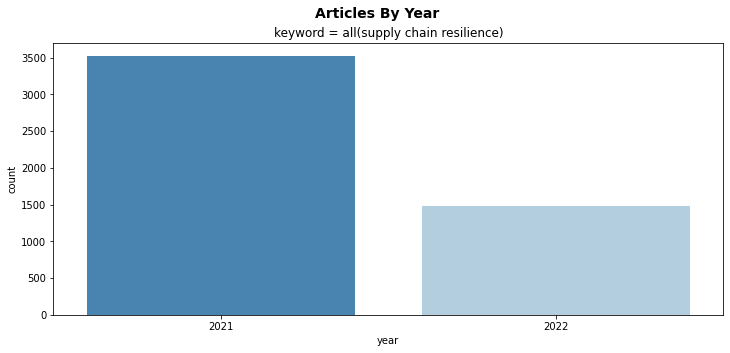

In [ ]:
#@markdown
plt.figure(figsize=(12,5))
sns.countplot(x='year', data=df, palette=sns.color_palette("Blues_r",2))

plt.suptitle('Articles By Year', fontsize=14, weight='bold')
plt.title('keyword = ' + keyword, fontsize=12)
plt.show()

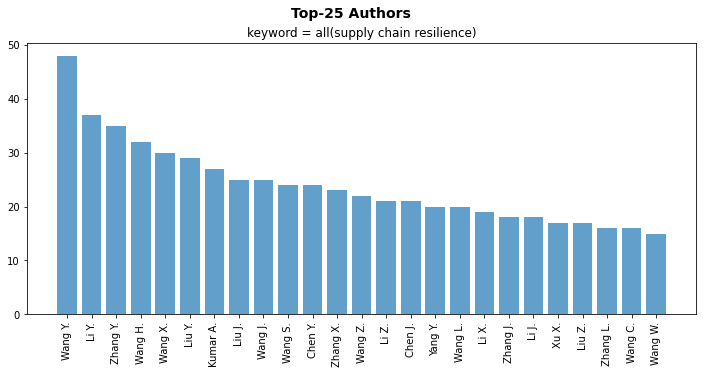

In [ ]:
#@markdown  
import matplotlib.pyplot as plt
%matplotlib inline

authors_dic = {}
for authors in df['authors']:
  authors_list = authors.split(',')
  for author in authors_list:
    a = author.lstrip().rstrip() # remove white spaces before and after
    if a not in authors_dic.keys():    
      authors_dic[a] = 1                    
    else:                                  
      authors_dic[a] =  authors_dic[a] + 1

# print(list(authors_dic.items())[:10])   

df_authors_count = pd.DataFrame(authors_dic.items(),  columns=['author', 'count']).sort_values('count',ascending=False)
df_authors_count = df_authors_count.sort_values('count',ascending=False)
df_authors_count = df_authors_count.reset_index(drop=True)
# df_authors_count.head()

df_authors_count = df_authors_count[df_authors_count.author != ''] # clear articles without authors!

df_authors_count = df_authors_count.head(25)

plt.figure(figsize=(12,5))
plt.bar(x=df_authors_count['author'], height=df_authors_count['count'],alpha=0.7)

plt.suptitle('Top-25 Authors', fontsize=14, weight='bold')
plt.title('keyword = ' + keyword, fontsize=12)
plt.xticks(rotation=90)
plt.show()



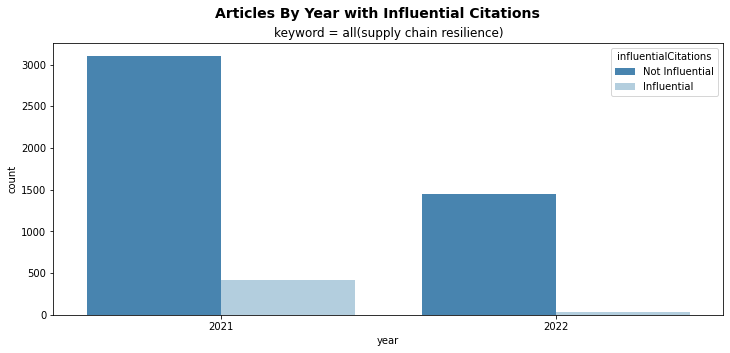

In [ ]:
#@markdown  
import seaborn as sns

df_2000 = df[ df.year > 2000 ].copy()
df_2000['influentialCitations'] = df.citationCount >= 6
df_2000['influentialCitations'] = df_2000['influentialCitations'].replace(True, 'Influential')
df_2000['influentialCitations'] = df_2000['influentialCitations'].replace(False, 'Not Influential')

plt.figure(figsize=(12,5))
sns.countplot(x='year', hue='influentialCitations', data=df_2000, palette=sns.color_palette("Blues_r",2))

plt.suptitle('Articles By Year with Influential Citations', fontsize=14, weight='bold')
plt.title('keyword = ' + keyword, fontsize=12)
plt.show()


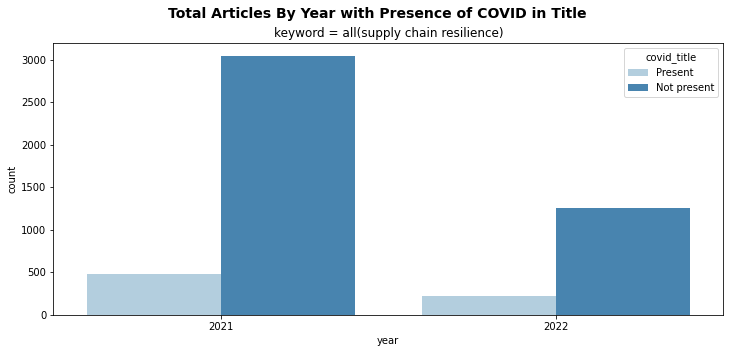

In [ ]:
#@markdown  
df_covid = df_2000[ (df_2000.year >= 2019) ].copy() 

df_covid['covid_title'] = df_covid['title'].str.lower().str.count('covid') > 0
df_covid['covid_title'] = df_covid['covid_title'].replace(True, 'Present')
df_covid['covid_title'] = df_covid['covid_title'].replace(False, 'Not present')

plt.figure(figsize=(12,5))
sns.countplot(x='year', hue='covid_title', data=df_covid, palette=sns.color_palette("Blues",2))

plt.suptitle('Total Articles By Year with Presence of COVID in Title', fontsize=14, weight='bold')
plt.title('keyword = ' + keyword, fontsize=12)
plt.show()

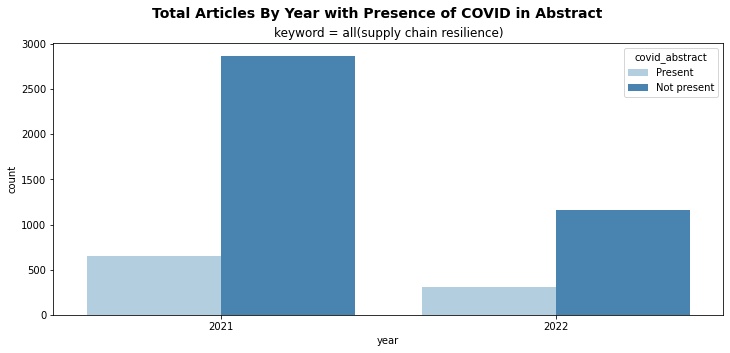

In [ ]:
#@markdown  
df_covid_abstract = df_2000[ (df_2000.year >= 2019) ].copy() 

df_covid_abstract['covid_abstract'] = df_covid_abstract['abstract'].str.lower().str.count('covid') > 0
df_covid_abstract['covid_abstract'] = df_covid_abstract['covid_abstract'].replace(True, 'Present')
df_covid_abstract['covid_abstract'] = df_covid_abstract['covid_abstract'].replace(False, 'Not present')

plt.figure(figsize=(12,5))
sns.countplot(x='year', hue='covid_abstract', data=df_covid_abstract, palette=sns.color_palette("Blues",2))

plt.suptitle('Total Articles By Year with Presence of COVID in Abstract', fontsize=14, weight='bold')
plt.title('keyword = ' + keyword, fontsize=12)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.




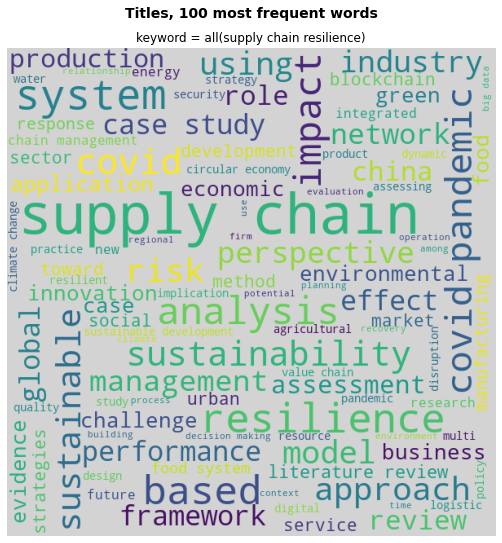

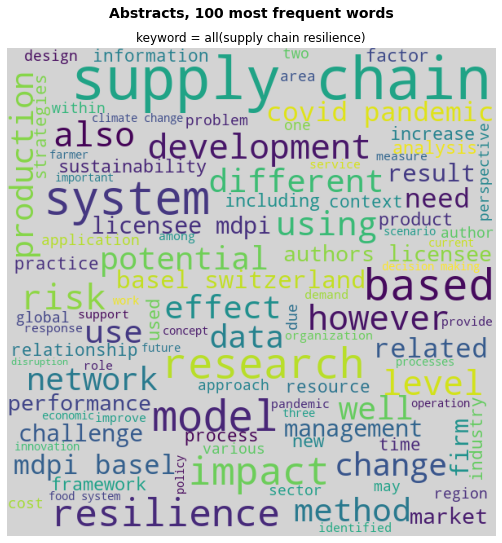

In [ ]:
#@markdown 
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def word_cloud(df,df_column,plot_title='Word Cloud',limit=100):

  stopwords_set = set( stopwords.words('english'))

  texto_string = ''
  for texto in df[df_column]:
    texto_string = texto_string + ' ' + texto.lower()  

  wordcloud = WordCloud(width = 600, height = 600,
          background_color ='lightgrey',
          max_words=limit,
          stopwords = stopwords_set,
          min_font_size = 10).generate(texto_string)

  print('\n')
  plt.figure(figsize = (7, 7), facecolor = None)
  plt.suptitle(plot_title, fontsize=14, weight='bold', y=1.05)
  plt.title('keyword = ' + keyword, fontsize=12)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

  return

word_cloud(df,'title',plot_title='Titles, 100 most frequent words')
word_cloud(df,'abstract',plot_title='Abstracts, 100 most frequent words')

